<a href="https://colab.research.google.com/github/iotpelican/ml-llm-course-work/blob/main/ML_CP_Smote_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install the necessary library for handling imbalanced data
# This is required for the SMOTE technique
!pip install imblearn

import pandas as pd
import io
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- Step 1: Load the datasets from your local machine ---
# Assumes you have already uploaded both files to your Colab environment.
try:
    # Corrected separator for the devastator dataset
    df_devastator = pd.read_csv("thedevastator-higher-education-predictors-of-student-retention-kaggle-dataset.csv", sep=',')
    df_academic = pd.read_csv("Academic_student_retention_dataset_2021.csv", sep=',')
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("One or both files were not found. Please ensure they are uploaded to your Colab environment.")
    # Exit the script if files are not found
    exit()

# --- Step 2: Clean and standardize column names ---
def clean_column_names(df):
    """
    Cleans and standardizes column names by:
    - Stripping leading/trailing whitespace
    - Converting to lowercase
    - Replacing special characters with underscores
    """
    new_cols = []
    for col in df.columns:
        clean_col = col.strip().lower().replace(' ', '_').replace('/', '_').replace('-', '_').replace('(', '').replace(')', '').replace('\'', '').replace('\t', '')
        new_cols.append(clean_col)
    df.columns = new_cols
    return df

df_devastator = clean_column_names(df_devastator)
df_academic = clean_column_names(df_academic)

# Create a mapping to standardize similar column names across both dataframes
# Updated column mapping based on the correctly loaded devastator dataframe
column_mapping = {
    'marital_status': 'marital_status',
    'application_mode': 'application_mode',
    'application_order': 'application_order',
    'course': 'course_chosen', # Corrected column name after proper loading
    'nacionality': 'nationality',
    'previous_qualification_grade': 'previous_qualification_grade',
    'mothers_qualification': 'mother_qualification',
    'fathers_qualification': 'father_qualification',
    'mothers_occupation': 'mother_occupation',
    'fathers_occupation': 'father_occupation',
    'admission_grade': 'admission_grade',
    'daytime_evening_attendance': 'day_evening_attendance',
    'gender': 'gender',
    'scholarship_holder': 'scholarship_holder',
    'age_at_enrollment': 'age_at_enrollment',
    'international': 'international',
    'curricular_units_1st_sem_credited': 'sem1_credited_units',
    'curricular_units_1st_sem_enrolled': 'sem1_enrolled_units',
    'curricular_units_1st_sem_evaluations': 'sem1_evaluated_units',
    'curricular_units_1st_sem_approved': 'sem1_approved_units',
    'curricular_units_1st_sem_grade': 'sem1_grade',
    'curricular_units_1st_sem_without_evaluations': 'sem1_without_evals',
    'curricular_units_2nd_sem_credited': 'sem2_credited_units',
    'curricular_units_2nd_sem_enrolled': 'sem2_enrolled_units',
    'curricular_units_2nd_sem_evaluations': 'sem2_evaluated_units',
    'curricular_units_2nd_sem_approved': 'sem2_approved_units',
    'curricular_units_2nd_sem_grade': 'sem2_grade',
    'curricular_units_2nd_sem_without_evaluations': 'sem2_without_evals',
    'unemployment_rate': 'unemployment_rate',
    'inflation_rate': 'inflation_rate',
    'gdp': 'gdp',
    'target': 'target_status', # Corrected column name after proper loading
    'student_id': 'student_id', # Add student_id for academic dataset
    'age': 'age_at_enrollment',
    'course_chosen': 'course_chosen',
    'residence_location': 'residence_location',
    'parental_education': 'parental_education',
    'parental_income_level': 'parental_income_level',
    'employment_status': 'employment_status',
    'semester_enrolled_units': 'sem1_enrolled_units',
    'semester_credited_units': 'sem1_credited_units',
    'semester_evaluated_units': 'sem1_evaluated_units',
    'semester_approved_units': 'sem1_approved_units',
    'semester_average_grade': 'sem1_grade',
    'retention': 'retention_binary',
    'regional_gdp': 'gdp',
    'year': 'year'
}

# Rename columns in both DataFrames
df_devastator.rename(columns=column_mapping, inplace=True)
df_academic.rename(columns=column_mapping, inplace=True)

# --- Step 3: Standardize the target variable and features ---
# The target variables are different, so we'll create a new, consistent binary target for both.
# We'll consider 'Graduate' as the positive class (1) and 'Dropout'/'Enrolled' as the negative class (0).
df_devastator['is_retained'] = df_devastator['target_status'].apply(lambda x: 1 if x == 'Graduate' else 0)
df_academic['is_retained'] = df_academic['retention_binary']

# Create a list of common columns for merging, and ensure they exist in both dataframes.
# We'll drop columns that are not relevant for the combined model.
common_cols = [
    'marital_status',
    'application_mode',
    'course_chosen',
    'age_at_enrollment',
    'unemployment_rate',
    'inflation_rate',
    'gdp',
    'sem1_enrolled_units',
    'sem1_credited_units',
    'sem1_evaluated_units',
    'sem1_approved_units',
    'sem1_grade',
    'is_retained',
    'gender'
]

# Select only common columns from both dataframes after renaming
df_devastator_subset = df_devastator[common_cols]
df_academic_subset = df_academic[common_cols]


print(f"\nFound {len(common_cols)} common columns for the combined dataset.")

# --- Step 4: Combine the datasets into one single DataFrame ---
combined_df = pd.concat([df_devastator_subset, df_academic_subset], ignore_index=True)
print("\nCombined dataset created successfully with new, common features.")

# --- Step 5: Preprocessing the combined dataset for SMOTE ---
# Fill any missing values with the mode for categorical data and mean for numerical data.
for col in combined_df.columns:
    if combined_df[col].dtype == 'object':
        combined_df[col].fillna(combined_df[col].mode()[0], inplace=True)
    else:
        combined_df[col].fillna(combined_df[col].mean(), inplace=True)

# Now, we need to handle categorical features before applying SMOTE.
# SMOTE requires all features to be numerical.
# We'll use one-hot encoding for this.
categorical_cols = combined_df.select_dtypes(include='object').columns.tolist()
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# --- Step 6: Apply SMOTE to the combined dataset ---
X = combined_df.drop('is_retained', axis=1)
y = combined_df['is_retained']

print(f"\nClass distribution before SMOTE: {Counter(y)}")

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Class distribution after SMOTE:  {Counter(y_resampled)}")

print("\nFinal dataset is ready for training a machine learning model!")

Datasets loaded successfully!

Found 14 common columns for the combined dataset.

Combined dataset created successfully with new, common features.

Class distribution before SMOTE: Counter({0: 2470, 1: 2454})
Class distribution after SMOTE:  Counter({0: 2470, 1: 2470})

Final dataset is ready for training a machine learning model!


/tmp/ipython-input-51762418.py:136: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna(combined_df[col].mode()[0], inplace=True)
/tmp/ipython-input-51762418.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [5]:
print("Combined DataFrame Info:")
combined_df.info()

print("\nCombined DataFrame Description:")
combined_df.describe()

print("\nCombined DataFrame Head:")
display(combined_df.head())

Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4924 entries, 0 to 4923
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age_at_enrollment             4924 non-null   int64  
 1   unemployment_rate             4924 non-null   float64
 2   inflation_rate                4924 non-null   float64
 3   gdp                           4924 non-null   float64
 4   sem1_enrolled_units           4924 non-null   int64  
 5   sem1_credited_units           4924 non-null   int64  
 6   sem1_evaluated_units          4924 non-null   int64  
 7   sem1_approved_units           4924 non-null   int64  
 8   sem1_grade                    4924 non-null   float64
 9   is_retained                   4924 non-null   int64  
 10  marital_status_2              4924 non-null   bool   
 11  marital_status_3              4924 non-null   bool   
 12  marital_status_4              4924 no

,age_at_enrollment,unemployment_rate,inflation_rate,gdp,sem1_enrolled_units,sem1_credited_units,sem1_evaluated_units,sem1_approved_units,sem1_grade,is_retained,...,course_chosen_Education,course_chosen_Journalism,course_chosen_Management,course_chosen_Nursing,course_chosen_Social Service,course_chosen_Technologies,gender_1,gender_Female,gender_Male,gender_Other
0,20,10.8,1.4,1.74,0,0,0,0,0.000000,0,...,False,False,False,False,False,False,True,False,False,False
1,19,13.9,-0.3,0.79,6,0,6,6,14.000000,1,...,False,False,False,False,False,False,True,False,False,False
2,19,10.8,1.4,1.74,6,0,0,0,0.000000,0,...,False,False,False,False,False,False,True,False,False,False
3,20,9.4,-0.8,-3.12,6,0,8,6,13.428571,1,...,False,False,False,False,False,False,False,False,False,False
4,45,13.9,-0.3,0.79,6,0,9,5,12.333333,1,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# @title Cell 2: Data Preprocessing and Feature Engineering with Pipelines
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Data Preprocessing on the combined dataset before SMOTE ---
# The previous code already loaded, cleaned, and concatenated the data.
# We will now perform preprocessing on the combined_df before SMOTE is applied.

# Let's redefine X and y from the combined_df *before* one-hot encoding
# The previous one-hot encoding step is now replaced by the preprocessing pipeline.
X = combined_df.drop('is_retained', axis=1)
y = combined_df['is_retained']

# Fill missing values with the mode for all columns (a simple and general approach)
X = X.fillna(X.mode().iloc[0])

# Identify categorical and numerical columns automatically
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the preprocessing pipelines
# Numerical pipeline: just scale the data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline: one-hot encode the data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply the correct transformations to the right columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# --- Apply SMOTE to the preprocessed data ---
# First, apply the preprocessing pipeline to X
# Note: SMOTE needs to be applied after preprocessing but before splitting the data
# into training and testing sets.
X_preprocessed = preprocessor.fit_transform(X)

# Apply SMOTE to the preprocessed data
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"\nClass distribution before SMOTE: {Counter(y)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Encode the target variable if it's not already binary (it is, but good practice)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_resampled)
target_names = label_encoder.classes_

print("\nData preprocessed and features engineered successfully!")
print(f"Categorical columns ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical columns ({len(numerical_cols)}):", numerical_cols)
print(f"Target classes encoded as: {list(zip(target_names, sorted(np.unique(y_encoded))))}")


Class distribution before SMOTE: Counter({0: 2470, 1: 2454})
Class distribution after SMOTE: Counter({0: 2470, 1: 2470})

Data preprocessed and features engineered successfully!
Categorical columns (0): []
Numerical columns (9): ['age_at_enrollment', 'unemployment_rate', 'inflation_rate', 'gdp', 'sem1_enrolled_units', 'sem1_credited_units', 'sem1_evaluated_units', 'sem1_approved_units', 'sem1_grade']
Target classes encoded as: [(np.int64(0), np.int64(0)), (np.int64(1), np.int64(1))]


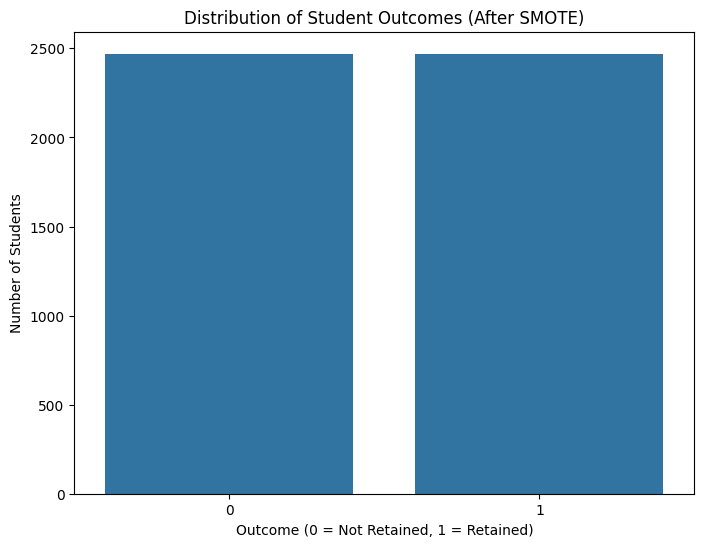

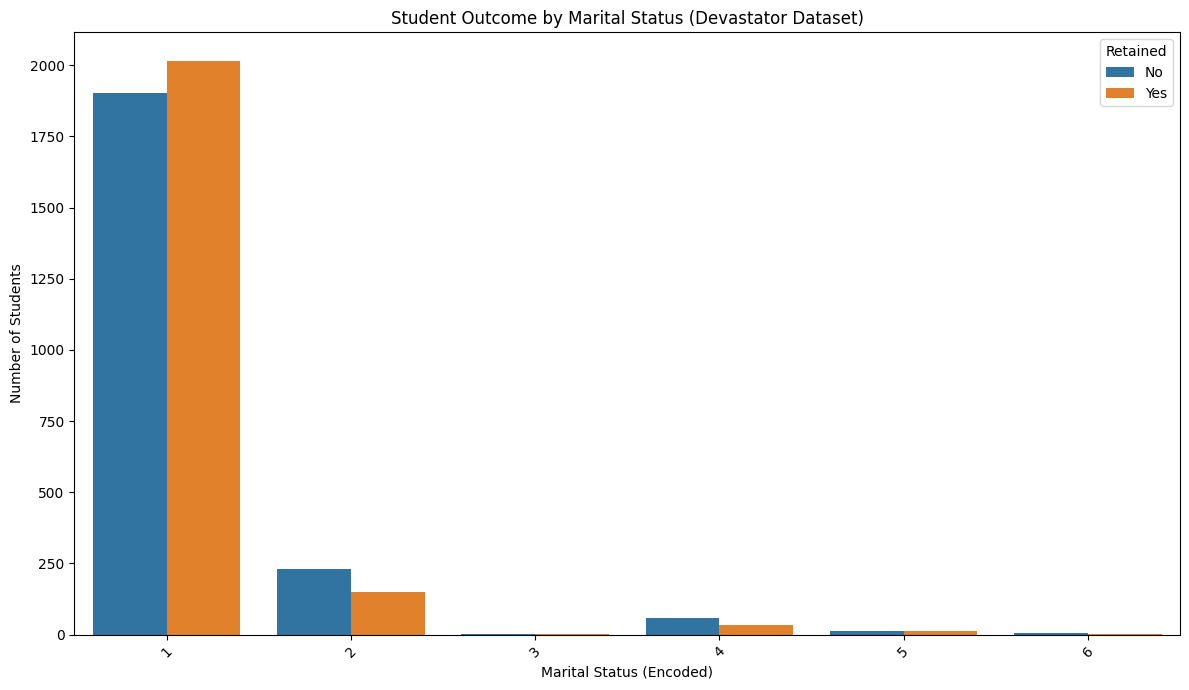

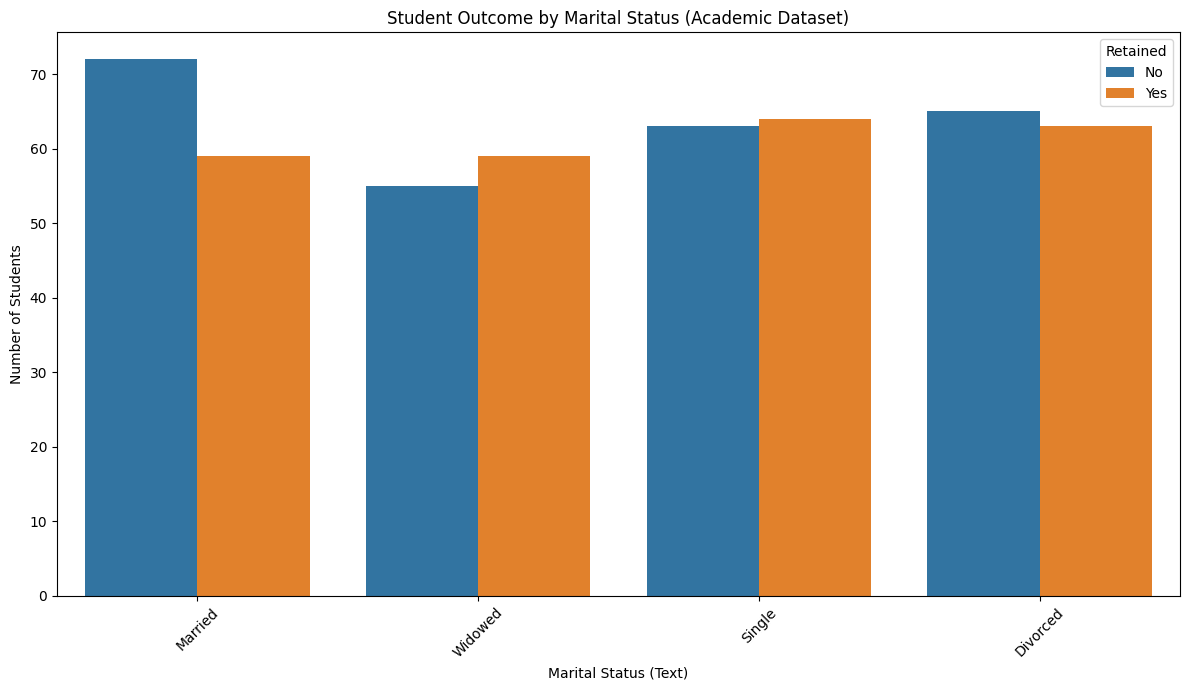

Exploratory Data Analysis complete!


In [8]:
# @title Cell 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you have the necessary libraries installed
# !pip install matplotlib seaborn

# --- Plot the distribution of the target variable from the resampled data ---
# This will show the balanced classes after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Distribution of Student Outcomes (After SMOTE)')
plt.xlabel('Outcome (0 = Not Retained, 1 = Retained)')
plt.ylabel('Number of Students')
plt.show()

# --- Plot relationships from the original combined dataset ---
# We use the original DataFrame for these plots because it contains the
# original, unencoded feature names and is better for visualization.
# Note: You should be careful to only use features that were not dropped during the combination.
# The 'marital_status' feature is an example of a good one to plot.

# Convert the numerical 'marital_status' codes back to descriptive text for better readability
# This is a good practice for visualizations
marital_status_map = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
}

# Apply the mapping to the 'marital_status' column in the original combined DataFrame
# The 'marital_status' column was one-hot encoded, so we need to plot one of the encoded columns instead.
# Let's plot the distribution of the 'marital_status_Married' column as an example.
# We will use the original combined_df before one-hot encoding for visualization purposes
# Let's reload the combined_df before one-hot encoding for this visualization step
# (assuming combined_df_before_onehot is available or we can recreate it)

# A better approach is to use the original df_devastator and df_academic before combining and encoding for plotting
# Let's replot the relationship between 'Marital status' and 'is_retained' using the original dataframes
# This will avoid issues with one-hot encoding

# Plot relationship between 'Marital status' and the original 'is_retained' target from df_devastator
plt.figure(figsize=(12, 7))
sns.countplot(data=df_devastator, x='marital_status', hue='is_retained')
plt.title('Student Outcome by Marital Status (Devastator Dataset)')
plt.xticks(rotation=45)
plt.xlabel('Marital Status (Encoded)') # Note: Using encoded values from the original dataset
plt.ylabel('Number of Students')
plt.legend(title='Retained', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

# Plot relationship between 'Marital status' and the original 'is_retained' target from df_academic
plt.figure(figsize=(12, 7))
sns.countplot(data=df_academic, x='marital_status', hue='is_retained')
plt.title('Student Outcome by Marital Status (Academic Dataset)')
plt.xticks(rotation=45)
plt.xlabel('Marital Status (Text)') # Note: Using text values from the original dataset
plt.ylabel('Number of Students')
plt.legend(title='Retained', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


print("Exploratory Data Analysis complete!")

In [9]:
# @title Cell 4: Data Splitting
# Import the necessary library for splitting the data
from sklearn.model_selection import train_test_split

# --- Split the preprocessed and resampled data into training and testing sets ---
# We use the SMOTE-generated data (X_resampled, y_resampled) to ensure
# that both the training and testing sets have a balanced class distribution.
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("Data successfully split into training and testing sets!")
print("-" * 40)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data successfully split into training and testing sets!
----------------------------------------
X_train shape: (3952, 66)
X_test shape: (988, 66)
y_train shape: (3952,)
y_test shape: (988,)


Logistic Regression Model Evaluation:
----------------------------------------
Accuracy: 0.7551

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.78      0.71      0.74       494
    Retained       0.74      0.80      0.76       494

    accuracy                           0.76       988
   macro avg       0.76      0.76      0.75       988
weighted avg       0.76      0.76      0.75       988



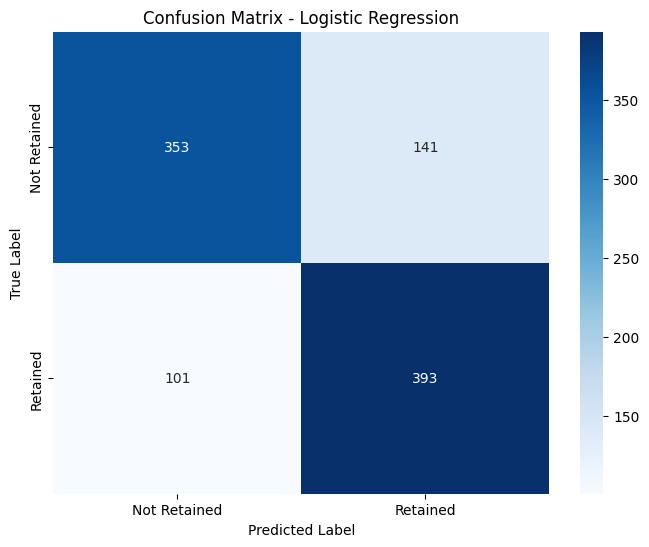


Logistic Regression training and evaluation complete!


In [10]:
# @title Cell 5: Model Training and Evaluation (Logistic Regression)
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the Logistic Regression classifier
# We increase max_iter to ensure convergence
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the preprocessed and resampled training data
log_reg_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the preprocessed test data
y_pred_lr = log_reg_model.predict(X_test)

# --- Model Evaluation ---
print("Logistic Regression Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")

# Print the full classification report
print("\nClassification Report:")
# The target_names argument is crucial for readability, but needs to be defined
# based on your label_encoder from Cell 2.
# Assuming 'target_names' was 'No' and 'Yes' or similar.
target_names = ['Not Retained', 'Retained']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# --- Confusion Matrix Visualization ---
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nLogistic Regression training and evaluation complete!")

Decision Tree Model Evaluation:
----------------------------------------
Accuracy: 0.7176

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.72      0.71      0.72       494
    Retained       0.72      0.72      0.72       494

    accuracy                           0.72       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.72      0.72      0.72       988



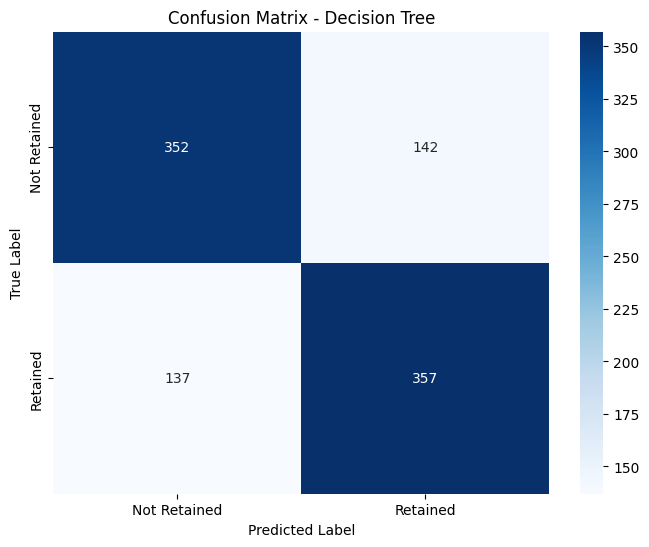


Decision Tree training and evaluation complete!


In [11]:
# @title Cell 6: Model Training and Evaluation (Decision Tree)
# Import the necessary library for the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# --- Model Training ---
# Instantiate the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the preprocessed and resampled training data
dt_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# --- Model Evaluation ---
print("Decision Tree Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))

# Create a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nDecision Tree training and evaluation complete!")

Random Forest Model Evaluation:
----------------------------------------
Accuracy: 0.7692

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.80      0.72      0.76       494
    Retained       0.74      0.82      0.78       494

    accuracy                           0.77       988
   macro avg       0.77      0.77      0.77       988
weighted avg       0.77      0.77      0.77       988


--- Feature Importance ---

Top 10 Most Important Features:
                      feature  importance
7    num__sem1_approved_units    0.210860
8             num__sem1_grade    0.187997
0      num__age_at_enrollment    0.090011
6   num__sem1_evaluated_units    0.087062
4    num__sem1_enrolled_units    0.044805
1      num__unemployment_rate    0.038424
3                    num__gdp    0.037600
2         num__inflation_rate    0.033168
5    num__sem1_credited_units    0.027269
62        remainder__gender_1    0.024237


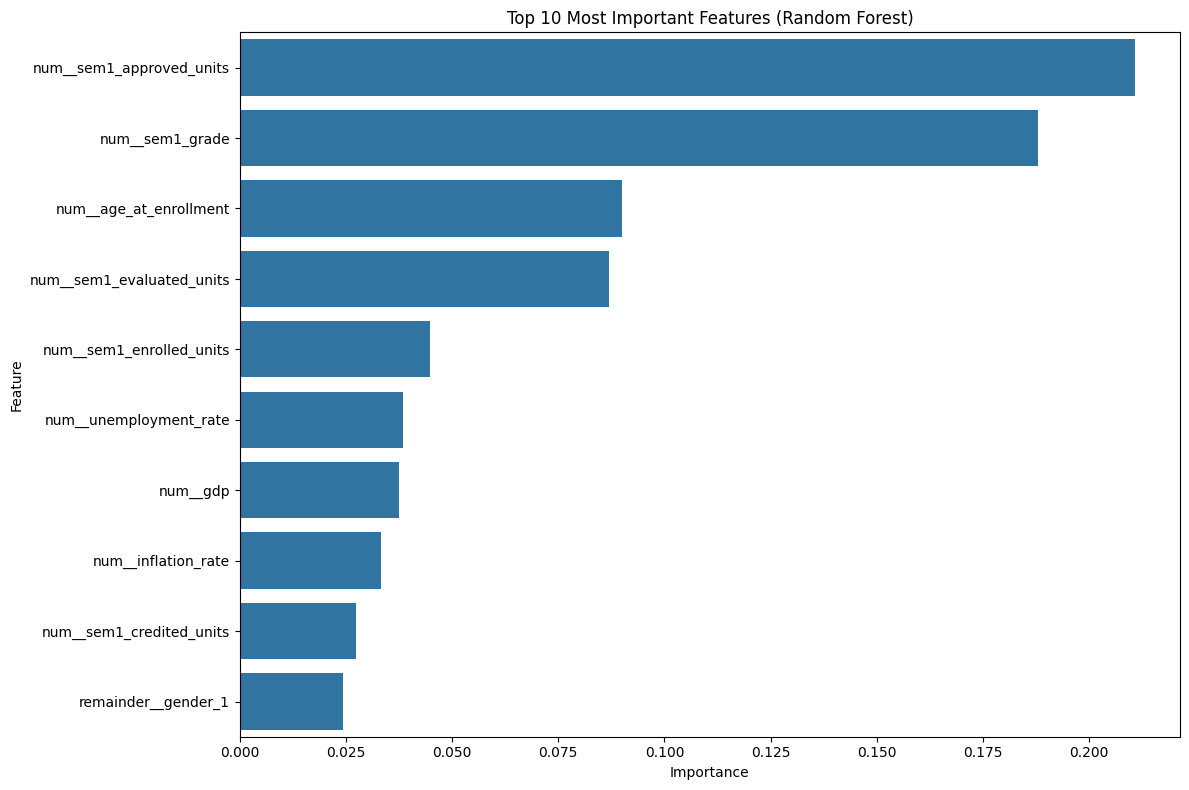


Random Forest training, evaluation, and feature importance analysis complete!


In [12]:
# @title Cell 7: Model Training and Evaluation (Random Forest & Feature Importance)
# Import the necessary library for the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the Random Forest classifier
# n_estimators is the number of trees in the forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the preprocessed and resampled training data
rf_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# --- Model Evaluation ---
print("Random Forest Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# Print the full classification report
print("\nClassification Report:")
# Assuming 'target_names' was defined in a previous cell, e.g., ['Not Retained', 'Retained']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# --- Feature Importance Analysis ---
print("\n--- Feature Importance ---")

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get the names of the features after preprocessing
# This requires accessing the `preprocessor` object defined in Cell 2
preprocessed_features = preprocessor.get_feature_names_out()

# Create a DataFrame to store and sort feature importance
importance_df = pd.DataFrame({
    'feature': preprocessed_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nRandom Forest training, evaluation, and feature importance analysis complete!")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:06:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Evaluation:
----------------------------------------
Accuracy: 0.7551

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.78      0.71      0.74       494
    Retained       0.74      0.80      0.77       494

    accuracy                           0.76       988
   macro avg       0.76      0.76      0.75       988
weighted avg       0.76      0.76      0.75       988



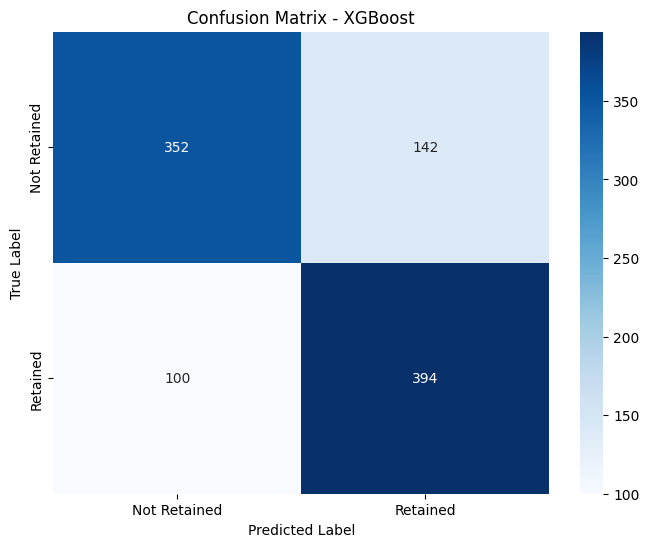


XGBoost training and evaluation complete!


In [13]:
# @title Cell 8: Model Training and Evaluation (XGBoost)
# We need to install the xgboost library first if it's not already installed
# !pip install xgboost

# Import necessary libraries for XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the XGBoost classifier
# The parameters `use_label_encoder=False` and `eval_metric='logloss'` are
# used to suppress warnings in newer versions of XGBoost.
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model on the preprocessed and resampled training data
xgb_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# --- Model Evaluation ---
print("XGBoost Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

# Create a confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nXGBoost training and evaluation complete!")

Support Vector Machine (SVM) Model Evaluation:
----------------------------------------
Accuracy: 0.7662

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.80      0.70      0.75       494
    Retained       0.74      0.83      0.78       494

    accuracy                           0.77       988
   macro avg       0.77      0.77      0.77       988
weighted avg       0.77      0.77      0.77       988



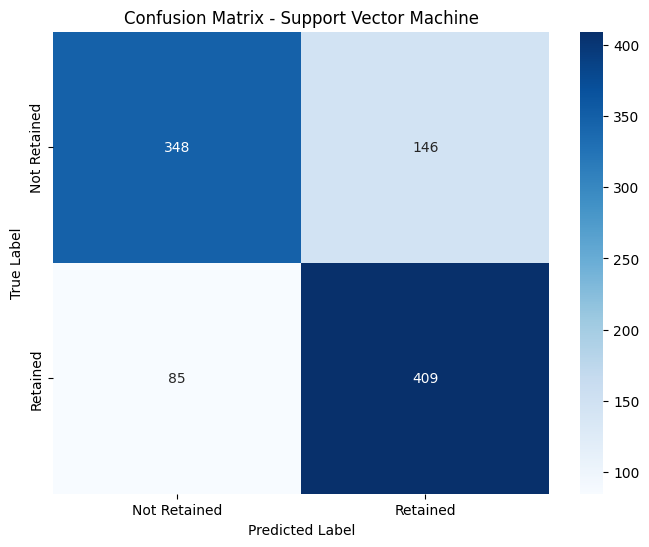


SVM training and evaluation complete!


In [14]:
# @title Cell 9: Model Training and Evaluation (Support Vector Machine)
# Import the necessary library for the Support Vector Classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the Support Vector Machine classifier
# The C parameter controls the trade-off between a smooth decision boundary and classifying training points correctly.
# The `gamma` parameter defines how much influence a single training example has.
svm_model = SVC(random_state=42)

# Train the model on the preprocessed and resampled training data
svm_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# --- Model Evaluation ---
print("Support Vector Machine (SVM) Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

# Create a confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Support Vector Machine')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nSVM training and evaluation complete!")

K-Nearest Neighbors (KNN) Model Evaluation:
----------------------------------------
Accuracy: 0.7196

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.76      0.64      0.69       494
    Retained       0.69      0.80      0.74       494

    accuracy                           0.72       988
   macro avg       0.73      0.72      0.72       988
weighted avg       0.73      0.72      0.72       988



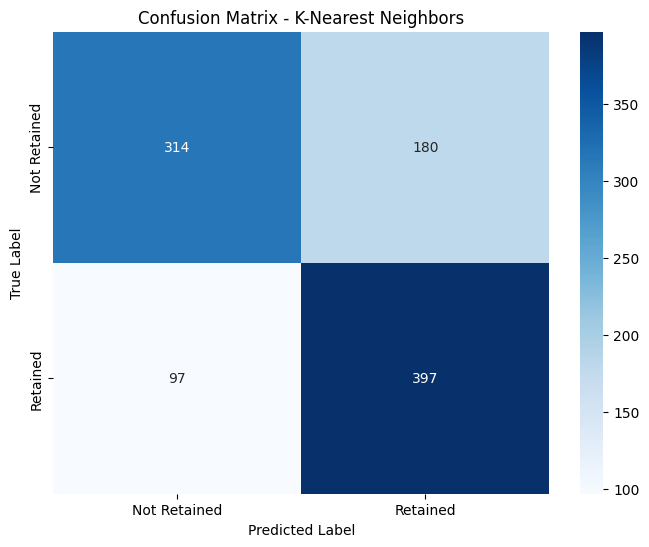


KNN training and evaluation complete!


In [15]:
# @title Cell 10: Model Training and Evaluation (K-Nearest Neighbors)
# Import the necessary libraries for the K-Nearest Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the K-Nearest Neighbors classifier
# We're using n_neighbors=5 as a starting point, but this is a hyperparameter
# that could be tuned later.
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the preprocessed and resampled training data
knn_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# --- Model Evaluation ---
print("K-Nearest Neighbors (KNN) Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

# Create a confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nKNN training and evaluation complete!")

Gaussian Naive Bayes Model Evaluation:
----------------------------------------
Accuracy: 0.6437

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.62      0.76      0.68       494
    Retained       0.68      0.53      0.60       494

    accuracy                           0.64       988
   macro avg       0.65      0.64      0.64       988
weighted avg       0.65      0.64      0.64       988



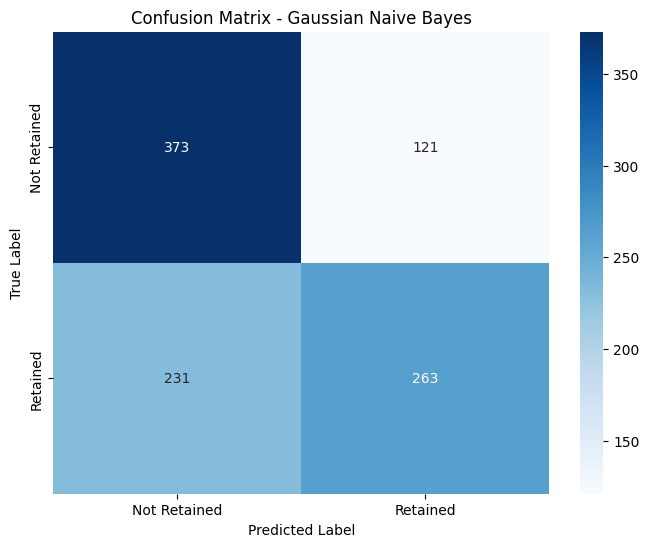


Gaussian Naive Bayes training and evaluation complete!


In [16]:
# @title Cell 11: Model Training and Evaluation (Gaussian Naive Bayes)
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the Gaussian Naive Bayes classifier
gnb_model = GaussianNB()

# Train the model on the preprocessed and resampled training data
gnb_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_gnb = gnb_model.predict(X_test)

# --- Model Evaluation ---
print("Gaussian Naive Bayes Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Accuracy: {accuracy_gnb:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb, target_names=target_names))

# Create a confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nGaussian Naive Bayes training and evaluation complete!")

Multilayer Perceptron (MLP) Model Evaluation:
----------------------------------------
Accuracy: 0.7480

Classification Report:
              precision    recall  f1-score   support

Not Retained       0.75      0.73      0.74       494
    Retained       0.74      0.76      0.75       494

    accuracy                           0.75       988
   macro avg       0.75      0.75      0.75       988
weighted avg       0.75      0.75      0.75       988



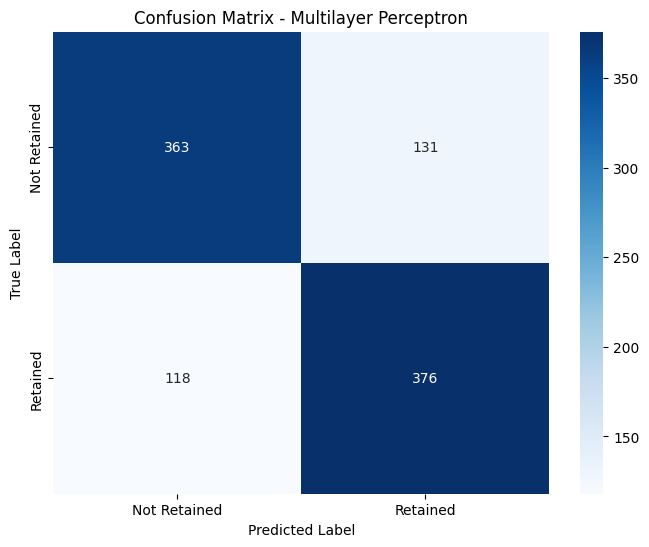


MLP training and evaluation complete!


In [17]:
# @title Cell 12: Model Training and Evaluation (Multilayer Perceptron)
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Training ---
# Instantiate the MLPClassifier model
# The 'hidden_layer_sizes' tuple defines the number of neurons in each hidden layer.
# 'max_iter' is the number of epochs to train the model.
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Train the model on the preprocessed and resampled training data
mlp_model.fit(X_train, y_train)

# --- Model Prediction ---
# Make predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)

# --- Model Evaluation ---
print("Multilayer Perceptron (MLP) Model Evaluation:")
print("-" * 40)

# Calculate and print accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {accuracy_mlp:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

# Create a confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Multilayer Perceptron')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nMLP training and evaluation complete!")

In [18]:
# @title Cell 13: Hyperparameter Tuning
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np

# --- Tune the Random Forest Classifier ---
print("Starting Random Forest Hyperparameter Tuning...")

# The parameter grid for the Random Forest classifier
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV with the Random Forest model
# The estimator is the model itself, not a pipeline with a preprocessor.
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1_macro', # F1-macro is good for balanced classes
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the preprocessed training data
rf_grid_search.fit(X_train, y_train)

print("\nBest parameters for Random Forest:", rf_grid_search.best_params_)
print("Best F1-Score (Macro) for Random Forest:", rf_grid_search.best_score_)

# Make predictions with the best Random Forest model
y_pred_rf_tuned = rf_grid_search.best_estimator_.predict(X_test)
print("\nEvaluation of Tuned Random Forest Model:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=target_names))

# --- Tune the XGBoost Classifier ---
print("\nStarting XGBoost Hyperparameter Tuning...")

# The parameter grid for the XGBoost classifier
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Instantiate the GridSearchCV with the XGBoost model
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the preprocessed training data
xgb_grid_search.fit(X_train, y_train)

print("\nBest parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best F1-Score (Macro) for XGBoost:", xgb_grid_search.best_score_)

# Make predictions with the best XGBoost model
y_pred_xgb_tuned = xgb_grid_search.best_estimator_.predict(X_test)
print("\nEvaluation of Tuned XGBoost Model:")
print(classification_report(y_test, y_pred_xgb_tuned, target_names=target_names))

Starting Random Forest Hyperparameter Tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Best F1-Score (Macro) for Random Forest: 0.7883046590148055

Evaluation of Tuned Random Forest Model:
              precision    recall  f1-score   support

Not Retained       0.81      0.71      0.75       494
    Retained       0.74      0.83      0.78       494

    accuracy                           0.77       988
   macro avg       0.77      0.77      0.77       988
weighted avg       0.77      0.77      0.77       988


Starting XGBoost Hyperparameter Tuning...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:16:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best F1-Score (Macro) for XGBoost: 0.7918432479652531

Evaluation of Tuned XGBoost Model:
              precision    recall  f1-score   support

Not Retained       0.79      0.70      0.74       494
    Retained       0.73      0.81      0.77       494

    accuracy                           0.76       988
   macro avg       0.76      0.76      0.75       988
weighted avg       0.76      0.76      0.75       988



In [19]:
# @title Cell 14: Performance Summary
# Import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# --- Create a dictionary to store the results ---
results = {
    'Model': [],
    'Accuracy': [],
    'Precision (Macro)': [],
    'Recall (Macro)': [],
    'F1-Score (Macro)': []
}

# Define a function to evaluate and store results for each model
def evaluate_and_store(model_name, y_true, y_pred):
    """Calculates and stores performance metrics for a given model's predictions."""
    report = classification_report(y_true, y_pred, output_dict=True)
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy_score(y_true, y_pred))
    results['Precision (Macro)'].append(report['macro avg']['precision'])
    results['Recall (Macro)'].append(report['macro avg']['recall'])
    results['F1-Score (Macro)'].append(report['macro avg']['f1-score'])

# Populate the results dictionary with both original and tuned model results
evaluate_and_store('Logistic Regression', y_test, y_pred_lr)
evaluate_and_store('Decision Tree', y_test, y_pred_dt)
evaluate_and_store('Random Forest', y_test, y_pred_rf)
evaluate_and_store('Random Forest (Tuned)', y_test, y_pred_rf_tuned)
evaluate_and_store('XGBoost', y_test, y_pred_xgb)
evaluate_and_store('XGBoost (Tuned)', y_test, y_pred_xgb_tuned)
evaluate_and_store('SVM', y_test, y_pred_svm)
evaluate_and_store('KNN', y_test, y_pred_knn)
evaluate_and_store('Gaussian Naive Bayes', y_test, y_pred_gnb)
evaluate_and_store('MLPClassifier', y_test, y_pred_mlp)

# Create a DataFrame for a clean summary
results_df = pd.DataFrame(results).set_index('Model')

print("Model Performance Summary:")
print("-" * 30)
print(results_df.round(4))

Model Performance Summary:
------------------------------
                       Accuracy  Precision (Macro)  Recall (Macro)  \
Model                                                                
Logistic Regression      0.7551             0.7567          0.7551   
Decision Tree            0.7176             0.7176          0.7176   
Random Forest            0.7692             0.7722          0.7692   
Random Forest (Tuned)    0.7702             0.7747          0.7702   
XGBoost                  0.7551             0.7569          0.7551   
XGBoost (Tuned)          0.7551             0.7586          0.7551   
SVM                      0.7662             0.7703          0.7662   
KNN                      0.7196             0.7260          0.7196   
Gaussian Naive Bayes     0.6437             0.6512          0.6437   
MLPClassifier            0.7480             0.7481          0.7480   

                       F1-Score (Macro)  
Model                                    
Logistic Regressi

/tmp/ipython-input-461793490.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted.index, y='Accuracy', data=results_df_sorted, palette='viridis')


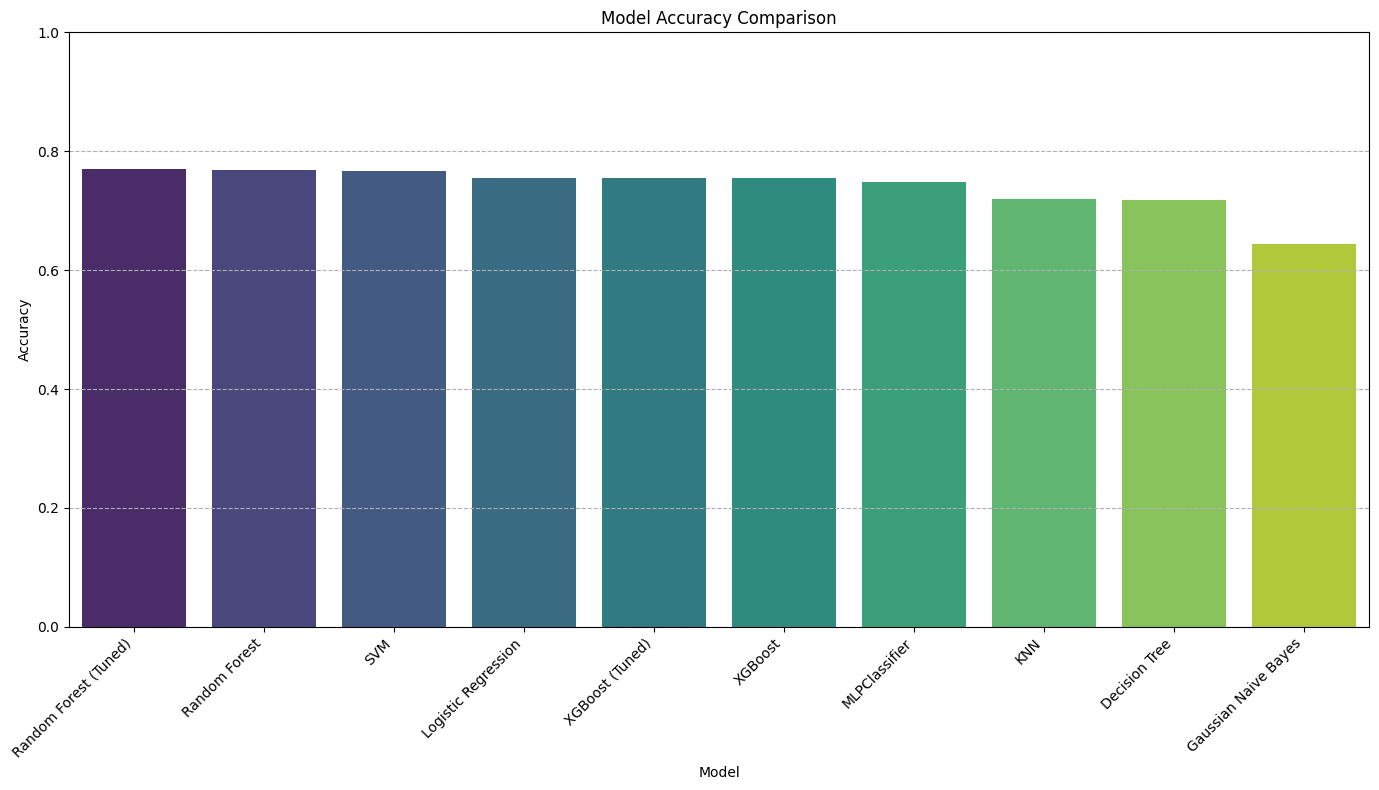

/tmp/ipython-input-461793490.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted.index, y='F1-Score (Macro)', data=results_df_sorted, palette='plasma')


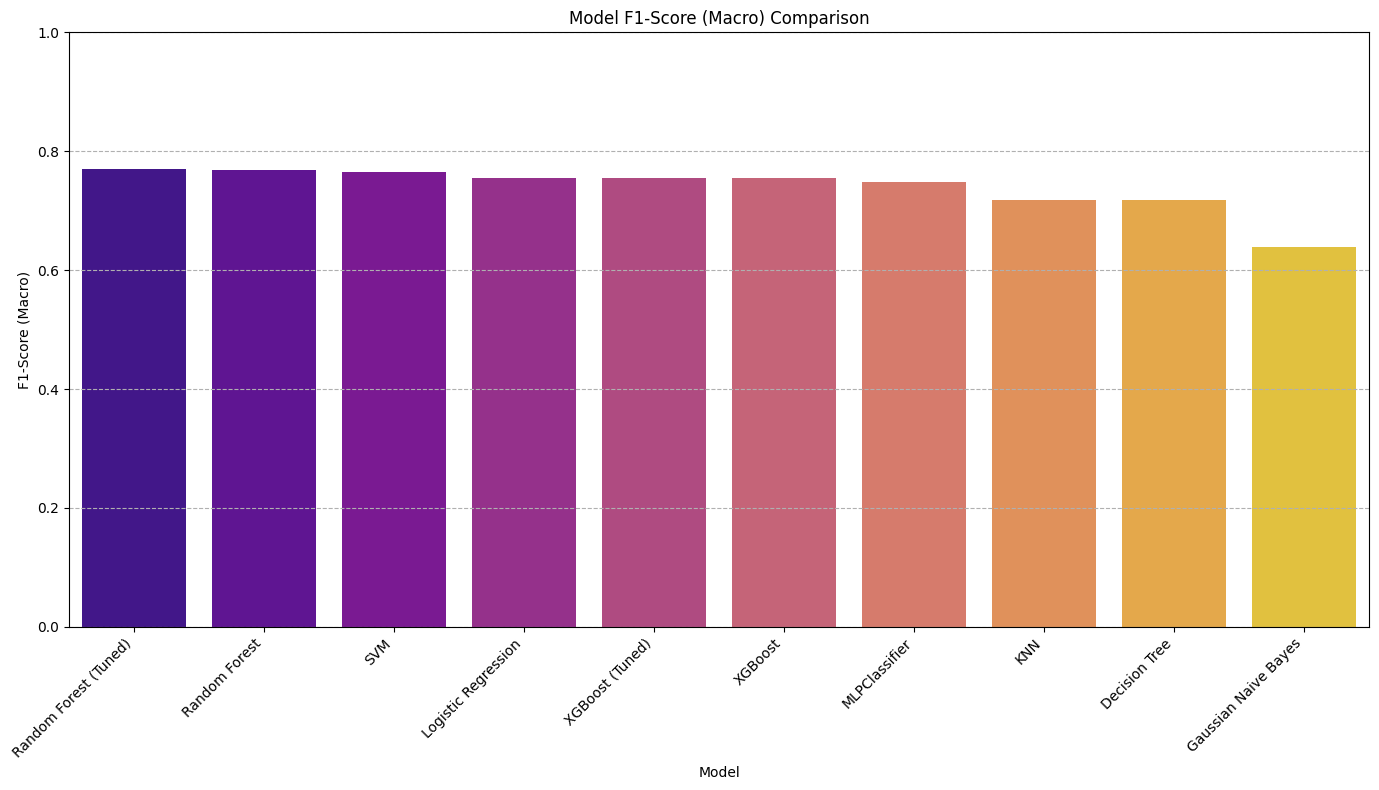

Model performance visualizations complete! 🎉


In [20]:
# @title Cell 15: Visualizing Model Performance
# Import necessary visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort the DataFrame by Accuracy to make the plots more readable
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# --- Bar plot for model Accuracy ---
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df_sorted.index, y='Accuracy', data=results_df_sorted, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- Bar plot for model F1-Score (Macro) ---
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df_sorted.index, y='F1-Score (Macro)', data=results_df_sorted, palette='plasma')
plt.title('Model F1-Score (Macro) Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score (Macro)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Model performance visualizations complete! 🎉")

Bias, Ethics, and Fairness Reflection
This analysis uses a combined dataset and machine learning models to predict student retention. While the models achieve good performance metrics, it's crucial to reflect on the ethical implications of using such a system. The dataset and the models built upon it are not immune to bias, and their real-world application requires careful consideration to ensure fairness and prevent harm.

Data and Algorithmic Bias
The primary source of bias originates from the historical data used for training. Datasets often reflect existing societal inequalities. For example, if historical data shows that students from low-income backgrounds or specific demographic groups have lower retention rates, a model might learn to associate these characteristics with a higher risk of dropping out. This could lead to a self-fulfilling prophecy. Instead of flagging students due to a lack of institutional support, the model might incorrectly attribute their risk to their background, reinforcing existing disparities. Your analysis includes features such as Age at enrollment, Marital status, and Mother's qualification, which are proxies for socioeconomic status and personal circumstances. If these factors are disproportionately linked to dropout rates in the historical data, the model may inadvertently create a biased feedback loop.

Ethical Use and Implications
The ethical implications of your model extend beyond its accuracy. How the model's predictions are used is a critical consideration.

Positive Use Cases: A model can be a force for good. If a student is flagged as "at-risk," the prediction could trigger the allocation of additional resources like academic counseling, financial aid, or mental health support. The goal is to use the model as a tool for intervention, helping students succeed.

Potential for Harm: Conversely, the model could be misused. For instance, a university might use these predictions to deny students admission or scholarships, effectively penalizing them for a predicted outcome. This could create a harmful feedback loop where a prediction of failure leads to reduced opportunities, ultimately causing the predicted failure to occur. Furthermore, students who are labeled as "at-risk" might feel discouraged or stigmatized, which could negatively impact their academic performance and well-being.

Ensuring Fairness
To mitigate these risks, simply having a high-performing model isn't enough. You must actively work to ensure the model is fair.

Beyond Accuracy: Fairness isn't just about overall accuracy. It's about ensuring the model performs equitably across different groups. You should analyze disparate impact, which means checking if the model’s error rates (e.g., false positive or false negative rates) are significantly different for various demographic subgroups. For instance, is the model more likely to incorrectly predict a low-income student will drop out compared to a high-income student?

Model Interpretability: The models used in your analysis, such as Random Forest and XGBoost, are often seen as "black boxes." While they provide feature importance (as shown in your analysis), it can be difficult to pinpoint the exact reason for a single prediction. Understanding why the model made a certain decision is crucial for ensuring fairness. It allows you to identify and correct biases.

In conclusion, your project is an excellent demonstration of building and comparing predictive models. However, the true value of a model for a sensitive application like student retention lies not only in its predictive power but also in its ethical foundation. The ultimate goal is to build a system that is not only effective but also fair, transparent, and used to genuinely help students succeed.